# Importing required modules

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

# Reading dataset

In [44]:
dt = pd.read_csv('FrenchMotorThirdPartyLiabilityClaims.csv') #specifying 1st column as row labels (called 'index')
#handle special variabes
del dt['IDpol'] #variables to exclude
yname = 'ClaimNb' #target variable

#specifying categorical variablese as type category
dt["VehBrand"] = dt["VehBrand"].astype("category")
dt["VehGas"] = dt["VehGas"].astype("category")
dt["Region"] = dt["Region"].astype("category")
dt["VehPower"] = dt["VehPower"].astype("category")

print(dt.head())

#delete any row with any missing value
dt.dropna(how='any', inplace=True)
if yname != dt.columns[0]:
    dt = dt[[yname] + list(dt.columns.drop(yname))]

#removing data errors, background research of dataset suggests values exceeding 4 for ClaimNb and 1 for Exposure are data errors
#source: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764
dt['ClaimNb'] = dt['ClaimNb'].clip(upper=4)
dt['Exposure'] = dt['Exposure'].clip(upper=1)
print(dt.head())

   ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0        1      0.10  'D'        5       0       55          50    'B12'   
1        1      0.77  'D'        5       0       55          50    'B12'   
2        1      0.75  'B'        6       2       52          50    'B12'   
3        1      0.09  'B'        7       0       46          50    'B12'   
4        1      0.84  'B'        7       0       46          50    'B12'   

      VehGas  Density Region  
0  'Regular'     1217  'R82'  
1  'Regular'     1217  'R82'  
2   'Diesel'       54  'R22'  
3   'Diesel'       76  'R72'  
4   'Diesel'       76  'R72'  
   ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0        1      0.10  'D'        5       0       55          50    'B12'   
1        1      0.77  'D'        5       0       55          50    'B12'   
2        1      0.75  'B'        6       2       52          50    'B12'   
3        1      0.09  'B'        7       0       46  

In [52]:
dt.describe()
#descriptive statistics of dataframe

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053179,0.528545,7.044265,45.499122,59.761502,1792.422405
std,0.237954,0.364081,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,11.000000,55.000000,64.000000,1658.000000
max,4.000000,1.000000,100.000000,100.000000,230.000000,27000.000000


# Outlier detection

In [3]:
# Automatic Outliers Detection

#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html

import time
st0 = time.time()
stm = st0

d = dt


cn = list(d)
#change any non-numeric y value to NaN
#delete any row where all x-variables are missing
d = d[cn].dropna(how='all')
#delete any column of constant values:
d = d[d.columns[d.nunique() > 1]]
#delete any non-numeric column and any column with any missing value:
for i in list(d):
    if pd.to_numeric(d[i], errors='coerce').isnull().any():
        del d[i]

# #random subsetting of rows: #only for demo purposes
# d = d.sample(10000)

r = len(d)

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print('Preparing data of', r, 'rows &', d.shape[1], 'columns took',
      '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Isolation Forest

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
from sklearn.ensemble import IsolationForest
#-1 in 'g' identifies an outlier position:
#g = IsolationForest().fit(d).fit_predict(d).tolist() #.fit(d) not necessary
g = IsolationForest(n_jobs=-1).fit_predict(d).tolist()
print('\nNumber of IsolationForest outliers:', g.count(-1))
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Local Outlier Factor

#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
from sklearn.neighbors import LocalOutlierFactor
a0 = LocalOutlierFactor(n_jobs=-1)
#-1 in 'a' identifies an outlier position:
a = a0.fit_predict(d).tolist()
ac = a.count(-1) #keep for EllipticEnvelope
an = a0.negative_outlier_factor_ #use this size info to rank outliers later
print('\nNumber of LocalOutlierFactor outliers:', ac)
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Elliptic Envelope for Gaussian distribution

#https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html
from sklearn.covariance import EllipticEnvelope
#-1 in 'e' identifies an outlier position:
e = EllipticEnvelope(contamination=min(0.1,ac/r)).fit_predict(d).tolist()
print('\nNumber of EllipticEnvelope outliers:', e.count(-1))
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

f = [-1 if s==-1 and t==-1 and u==-1 else 1 for s, t, u in zip(a, g, e)]
p = f.count(-1)

if p > 0:
    outliers = [i for i, z in enumerate(f) if z == -1] #indices of outliers
    q = [z for _, z in sorted(zip(an[outliers], outliers))][:100] #indices of sorted worst outliers
    print('\nNumber of outliers common to all lists:', p,
          '\nIndices of up to 100 sorted outliers with the worst first:', q,
          'from [0 to', str(r - 1) + '].')
    print('\nProportion of data outlying:', '%.5f' % (p / r))
else:
    print('\nNo outlier common to all lists.')
print('\nOutliers detection took', '%.2f' % ((time.time() - st0) / 60), 'mins.')

Preparing data of 678013 rows & 7 columns took 0.10 mins.

Number of IsolationForest outliers: 126556
... took 1.02 mins.

Number of LocalOutlierFactor outliers: 13055
... took 4.11 mins.

Number of EllipticEnvelope outliers: 13055
... took 7.97 mins.

Number of outliers common to all lists: 329 
Indices of up to 100 sorted outliers with the worst first: [656061, 656062, 513763, 619849, 619850, 513764, 66501, 131057, 43222, 43221, 15667, 208444, 208446, 364706, 15433, 225383, 107605, 18711, 524038, 384611, 17577, 17578, 563287, 437845, 219315, 278242, 100062, 593394, 366259, 210390, 601981, 147190, 6654, 26530, 437867, 124746, 278264, 259429, 36551, 36552, 546549, 147191, 4510, 415287, 512418, 512419, 366260, 115586, 25238, 1865, 621341, 514922, 514923, 648975, 496776, 658649, 22240, 217897, 516545, 520581, 520582, 366693, 629609, 487918, 45884, 210983, 563294, 650234, 623996, 197734, 192478, 133817, 456296, 618194, 676156, 676154, 676157, 676155, 663851, 663852, 611623, 658273, 63950,

# Dropping detected outliers

In [45]:
dt_droppedoutliers = dt.drop(outliers)

# Interactions

In [20]:
df = dt_droppedoutliers
y = 'ClaimNb'

pd.options.mode.chained_assignment = None  # default='warn'
#get column names:
colname = list(df)
#move y to position 0:
colname.insert(0, colname.pop(colname.index(y)))
df = df[colname]
print(df.head())

#transform all Xs into cube & cube-root, using np.cbrt()

trf = ['_cube', '_cbrt'] #may be adapted for square & square-root

import numpy as np

for i in list(df)[1:]:
    try:
        df[i + trf[0]] = df[i] ** (3. if '_cube' in trf else 2.)
        df[i + trf[1]] = np.cbrt(df[i]) if '_cube' in trf else np.sqrt(df[i])
    except:
        #column cannot be transformed
        #delete non-numeric column (with no questions asked!):
        df.drop(i, axis=1, inplace=True)

#only numeric columns left
df0 = df.copy() #kept for inclusion of interaction variables later
    
#perform feature selection using adjusted R2

modeleq = ' + '.join(list(df)).replace('+', '~', 1)
print('\n',modeleq)
maxR2 = -np.inf
bmodeleq = modeleq
numx = df.shape[1] - 1
x1x2 = False #interaction variables not yet included

from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df).fit()
    R2 = regout.rsquared_adj
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq
#     if R2 == 0:
#         break

    print('\nAdjusted R2 =', R2, 'for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break
            
        else:
            #add interaction variables for original untransformed variables in best model so far
            
            numx = bmodeleq.count('+') + 1
            print('\nRestarting from best model (with', numx, 'Xs) found so far...')
            
            colname = bmodeleq.replace('~', '+').split(' + ')
            df = df0[colname]
            colname = colname[1:] #remove y
            
            for i in range(numx):
                #look for 1st transformed variable:
                if colname[i][-5:] in trf:
                    i = i - 1
                    #colname[i] is the last untransformed x
                    break
            
            print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                  'untransformed variables in best model found so far:')
            for j in range(i):
                #untransformed x in colname up to [i]
                for k in range(j + 1, i + 1):
                    a = colname[j] + '_x_' + colname[k]
                    print(a)
                    df[a] = df[colname[j]] * df[colname[k]]
                    
            df0 = df.copy()
                    
            #delete any x too highly correlated with another x, to avoid collinearity
            
            corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
            for x in list(df)[1:]:
                #during 1st time thru loop, new column, with label, created in empty dataframe
                corv.loc[x, y] = df[x].corr(df[y]) #new entry, with row label, added to dataframe
                
            corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked 
            modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            numx = df0.shape[1] - 1
            x1x2 = True #interaction variables already included
            
            #beyond-pairwise collinearity may still be introduced with the interaction variables
            
            df = df0.copy() #ready for continuing deletion
            continue

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

print('\nBest model has', bmodeleq.count('+') + 1, 'Xs:')
out = ols(bmodeleq, df0).fit()
#collinearity is still entirely possible at this stage
print(out.summary2())

print("\nDescending order of X's significance:")
print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
#if the single best variable isn't high in above ranking, collinearity might be an issue


   ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0        1      0.10  'D'        5       0       55          50    'B12'   
1        1      0.77  'D'        5       0       55          50    'B12'   
2        1      0.75  'B'        6       2       52          50    'B12'   
3        1      0.09  'B'        7       0       46          50    'B12'   
4        1      0.84  'B'        7       0       46          50    'B12'   

      VehGas  Density Region  
0  'Regular'     1217  'R82'  
1  'Regular'     1217  'R82'  
2   'Diesel'       54  'R22'  
3   'Diesel'       76  'R72'  
4   'Diesel'       76  'R72'  

 ClaimNb ~ Exposure + VehAge + DrivAge + BonusMalus + Density + Exposure_cube + Exposure_cbrt + VehAge_cube + VehAge_cbrt + DrivAge_cube + DrivAge_cbrt + BonusMalus_cube + BonusMalus_cbrt + Density_cube + Density_cbrt

Adjusted R2 = 0.014471491833681127 for 15 Xs.
Variable to drop: Exposure_cbrt

Adjusted R2 = 0.01447096648996038 for 14 Xs.
Variable to d

ClaimNb                  0
Exposure                 0
VehAge                   0
DrivAge                  0
BonusMalus               0
Density                  0
Exposure_cube            0
Exposure_cbrt            0
VehAge_cube              0
VehAge_cbrt              0
DrivAge_cube             0
DrivAge_cbrt             0
BonusMalus_cube          0
BonusMalus_cbrt          0
Density_cube             0
Density_cbrt             0
Exposure_x_VehAge        0
Exposure_x_DrivAge       0
Exposure_x_BonusMalus    0
Exposure_x_Density       0
VehAge_x_DrivAge         0
VehAge_x_BonusMalus      0
VehAge_x_Density         0
DrivAge_x_BonusMalus     0
DrivAge_x_Density        0
BonusMalus_x_Density     0
dtype: int64

# Collinearity

In [22]:
#code has been modified from Regression_Collinearity.ipynb to use the bmodeleq output from previous step (Interactions) as input for this step
#delete non-numeric columns:
df = df0.select_dtypes(['number'])

#get column names:
colname = list(df0)
#move y to position 0:
colname.insert(0, colname.pop(colname.index(y)))
df = df[colname]

df0 = df.copy()

#delete any x too highly correlated with another x, to avoid collinearity

corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
for x in list(df)[1:]:
    #during 1st time thru loop, new column, with label, created in empty dataframe
    corv.loc[x, y] = df[x].corr(df[y]) #new entry, with row label, added to dataframe

corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked

delta = 0.005 #corr difference lower limit
dl2 = []
icorr = True
while icorr:
    a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
    colname = list(df)[1:]
    dl = []
    print('\nX pairs with correlations >', 1 - delta, ':')
    for b in range(1, a.shape[0]):
        if a.iloc[b, 0]:
            if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                #deleting 1 X from correlated pair:
                dv0 = a.index[b - 1]
                dv1 = a.index[b]

                #neither should already be deleted:
                if not (dv0 in dl) and not (dv1 in dl):
                    #delete x with rather lower corr(x, y):
                    if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                        d = dv1
                    elif len(dv0) < len(dv1): #delete x with longer name:
                        d = dv1
                    else:
                        d = dv0

                    dl.append(d) #for en masse deletion later
                    corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                    print(dv0,',',dv1)

    if len(dl) > 0:
        df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
        dl2 = dl2 + dl #keep for real deletion later
        print('\n' + str(len(dl)), 'variables considered for deletion:')
        print('\n'.join([str(x) for x in dl]))
    else:
        print('(no more)')
        icorr = False

#remaining Xs may be collinear
print('\n' + str(len(dl2)), 'collinear variables deleted.')

#potential collinearity issues handled

df0 = df.copy() #kept for inclusion of interaction variables later
#df = df0
    
#perform feature selection using adjusted R2

modeleq = ' + '.join(list(df)).replace('+', '~', 1)
#print(modeleq)

import numpy as np
maxR2 = -np.inf
bmodeleq = bmodeleq
numx = df.shape[1] - 1

from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df).fit()
    R2 = regout.rsquared_adj
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq

    print('\nAdjusted R2 =', R2, 'for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        #one xvar left
        #get out of 'while' loop:
        break
            
    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

print('\nBest model has', bmodeleq.count('+') + 1, 'Xs:')
out = ols(bmodeleq, df0).fit()
#collinearity is still entirely possible at this stage
print(out.summary2())

print("\nDescending order of X's significance:")
print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
#if the single best variable isn't high in above ranking, collinearity might be an issue
print(df0.head())
print(df.head())


X pairs with correlations > 0.995 :
BonusMalus_cbrt , BonusMalus

1 variables considered for deletion:
BonusMalus_cbrt

X pairs with correlations > 0.995 :
(no more)

1 collinear variables deleted.

Adjusted R2 = 0.018363222791674683 for 24 Xs.
Variable to drop: VehAge_x_BonusMalus

Adjusted R2 = 0.018364382400966606 for 23 Xs.
Variable to drop: Exposure_x_Density

Adjusted R2 = 0.018364927227048522 for 22 Xs.
Variable to drop: VehAge_x_Density

Adjusted R2 = 0.018365182865581753 for 21 Xs.
Variable to drop: Density

Adjusted R2 = 0.01836487008068033 for 20 Xs.
Variable to drop: Exposure_cube

Adjusted R2 = 0.018359453527131753 for 19 Xs.
Variable to drop: Exposure_cbrt

Adjusted R2 = 0.01836000689001227 for 18 Xs.
Variable to drop: Density_cube

Adjusted R2 = 0.018351362287625128 for 17 Xs.
Variable to drop: DrivAge_x_Density

Adjusted R2 = 0.018349992343475008 for 16 Xs.
Variable to drop: VehAge_x_DrivAge

Adjusted R2 = 0.018334907737532213 for 15 Xs.
Variable to drop: DrivAge_cbrt


In [23]:
df0.isna().sum()

ClaimNb                  0
Exposure                 0
VehAge                   0
DrivAge                  0
BonusMalus               0
Density                  0
Exposure_cube            0
Exposure_cbrt            0
VehAge_cube              0
VehAge_cbrt              0
DrivAge_cube             0
DrivAge_cbrt             0
BonusMalus_cube          0
Density_cube             0
Density_cbrt             0
Exposure_x_VehAge        0
Exposure_x_DrivAge       0
Exposure_x_BonusMalus    0
Exposure_x_Density       0
VehAge_x_DrivAge         0
VehAge_x_BonusMalus      0
VehAge_x_Density         0
DrivAge_x_BonusMalus     0
DrivAge_x_Density        0
BonusMalus_x_Density     0
dtype: int64

# Pulling values for X and y, splitting for train and test

In [26]:
category_df = dt_droppedoutliers.select_dtypes(include=['category']).copy()
#selecting only columns of the categorical type from our original dataframe
print(category_df.head())
df1 = pd.concat([df0,category_df], axis=1)
#adding back categorical data into the output dataframe of our Interaction and Collinearity sections, since categorical data was dropped earlier in Interactions
print(df1.head())
y = df1.iloc[:, 0]
X = df1.iloc[:, 1:]
#splitting our combined dataframe into our dependent variable ClaimNb, with all other variables as independent variables

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=1)
#splitting data into test and train

datatrain = pd.concat([ytr,Xtr],axis=1)
#concatenate X train and y train into one dataframe, as we are using statsmodels.formula which accepts one dataframe and one modeleq as input rather than two dataframes (X and y)

  VehPower VehBrand     VehGas Region
0        5    'B12'  'Regular'  'R82'
1        5    'B12'  'Regular'  'R82'
2        6    'B12'   'Diesel'  'R22'
3        7    'B12'   'Diesel'  'R72'
4        7    'B12'   'Diesel'  'R72'
ClaimNb                  0
Exposure                 0
VehAge                   0
DrivAge                  0
BonusMalus               0
Density                  0
Exposure_cube            0
Exposure_cbrt            0
VehAge_cube              0
VehAge_cbrt              0
DrivAge_cube             0
DrivAge_cbrt             0
BonusMalus_cube          0
Density_cube             0
Density_cbrt             0
Exposure_x_VehAge        0
Exposure_x_DrivAge       0
Exposure_x_BonusMalus    0
Exposure_x_Density       0
VehAge_x_DrivAge         0
VehAge_x_BonusMalus      0
VehAge_x_Density         0
DrivAge_x_BonusMalus     0
DrivAge_x_Density        0
BonusMalus_x_Density     0
VehPower                 0
VehBrand                 0
VehGas                   0
Region          

# Variable selection

In [27]:
#modified from Regression_Feature_Selection.ipynb to return the finalmodeleq instead of out such that it is stored as a global variable and called be called upon in the following segments
import warnings
warnings.filterwarnings('ignore')  #suppress warning messages (those with peach background)

def mr(selection=False):
    h = datatrain #use 1st column as row labels
    #print(h.head(0)) # dataset's variable names
    print('\nThe dataset has', len(h), 'rows and', h.shape[1], 'columns.', '' if selection else '\n')
    yvar = 'ClaimNb'
    
    modeleq = ' + '.join(list(datatrain)).replace('+', '~', 1)

    bmodeleq = modeleq
    
    if selection:
        #eliminate X variables one by one:
        print('\nVariable Selection using t-stat p-value & PR(>F):')
        
        #initialize p-value & adjusted R2:
        #set to infinity (or import sys; sys.maxsize) (or max=1.7976931348623157e+308 min=2.2250738585072014e-308) :
        minfpv = np.inf #f-stat p-value
        maxadjR2 = -minfpv

        #machine learns:
        while True:
            hout = ols(modeleq, h).fit()
            #print(dir(hout)) # gives all the attributes of .fit(), e.g. .fvalue & .f_pvalue

            fpv = hout.f_pvalue
            #see if a better model (smaller F-stat p-value) is found:
            if fpv < minfpv:
                minfpv = fpv
                maxadjR2 = hout.rsquared_adj
                bmodeleq = modeleq
            elif fpv == 0.0:
                #resolve using adjusted R2:
                if hout.rsquared_adj >= maxadjR2:
                    minfpv = fpv
                    maxadjR2 = hout.rsquared_adj
                    bmodeleq = modeleq
                
            numx = modeleq.count(' + ')
            print('\nF-statistic =', hout.fvalue, '       PR(>F) =', fpv, 'for', numx + 1, 'Xs.')

            if modeleq.find(' + ') == -1:
                # 1 xvar left
                # adjusted-R2 for no xvar (fit is y-bar) is 0; consider if adjusted-R2 < 0 for 1 xvar
                break

            #identify X variable to delete by finding the one with largest t-stat p-value (equivalently, PR>F):
            prf = sm.stats.anova_lm(hout, typ=2).iloc[:-1, :].sort_values(['F']
                                ).sort_values(['df'], ascending=False)['PR(>F)']
            maxp = max(prf)
            #print('\n',dict(prf))
            xdrop = prf[maxp == prf].axes[0][0]  # 1st element of row-label .axes[0]

            # xdrop removed from model equation:
            if (modeleq.find('~ ' + xdrop + ' + ') != -1): #xdrop is 1st x
                modeleq = modeleq.replace('~ ' + xdrop + ' + ', '~ ')
            elif (modeleq.find('+ ' + xdrop + ' + ') != -1):
                modeleq = modeleq.replace('+ ' + xdrop + ' + ', '+ ')
            else: #xdrop is last x
                modeleq = modeleq.replace(' + ' + xdrop, '')
            #print('Model equation:',modeleq,'\n')

            #print(prf)
            print('Variable to drop:', xdrop, '       p-value =', prf[xdrop])

        #machine learnt
        
        print('Variable left:', prf.loc[~prf.index.isin([xdrop])].axes[0][0])
        print('\nBest model equation:', bmodeleq)
        print('\nMinimum PR(>F) =', minfpv, 'for', bmodeleq.count(' + ') + 1, 'Xs.\n')

    hout = ols(bmodeleq, h).fit()
    #return hout
    finalmodeleq = bmodeleq
    return finalmodeleq
    #any categorical variable first, then in descending order of F-stat; but ultimately ascending order of PR(>F):
    hlm = sm.stats.anova_lm(hout, typ=2).sort_values(['df', 'F'], ascending=False).sort_values(['PR(>F)'])
    last = sum(hlm['df'][:-1] == 1.0)  #number of hout. bottom t-stats for numeric Xs to display with more precision
    if len(hlm) > last + 1:
        #print the coefficient table:
        print(hlm.replace(np.nan, ''), '\n')

    hsum = hout.summary2()
    #print the ANOVA table, and more:
    print(hsum)

    #construct and print the numeric variables in order of importance:
    
    #p-values are the same as PR(>F) from .anova_lm typ=2 & typ=3
    print('\n' + str(last) + (' quantitative' if len(hlm) > last + 1 else ''), "X-coefficients' |t-stats| ranked:")
    nxvar = len(hout.tvalues)
    #print(pd.concat([hout.tvalues[nxvar-last:nxvar],abs(hout.tvalues[nxvar-last:nxvar])],axis=1)
    #      .sort_values(1, ascending=False)[0])
    
    c = pd.Series(hout.params[nxvar - last:nxvar].index, index=hout.params[nxvar - last:nxvar].index)
    h2 = pd.concat([c, hout.params[nxvar - last:nxvar], hout.tvalues[nxvar - last:nxvar], hout.pvalues[nxvar - last:nxvar],
        abs(hout.tvalues[nxvar - last:nxvar])], axis=1).sort_values(4, ascending=False).iloc[:, :-1]
    h2.columns = ['', 'Coefficient', 't-stat', 'P>|t|']
    h2.index = np.arange(1, len(h2) + 1)
    print(h2)

    #output specific table (works when done outside a function):
    #from IPython.core.display import HTML
    #HTML(hout.summary().tables[1].as_html()) #.tables[] from 0 to 2
    2
finalmodeleq = mr(True) # do Variable Selection


The dataset has 508263 rows and 29 columns. 

Variable Selection using t-stat p-value & PR(>F):

F-statistic = 156.73832861003353        PR(>F) = 0.0 for 28 Xs.
Variable to drop: Density        p-value = 0.6615810191939168

F-statistic = 159.18470590866892        PR(>F) = 0.0 for 27 Xs.
Variable to drop: Exposure_x_Density        p-value = 0.6884471747800495

F-statistic = 161.70897119398964        PR(>F) = 0.0 for 26 Xs.
Variable to drop: VehAge_x_BonusMalus        p-value = 0.44557336786865076

F-statistic = 164.30804875788064        PR(>F) = 0.0 for 25 Xs.
Variable to drop: Exposure_cube        p-value = 0.1600183577302097

F-statistic = 164.27643158973044        PR(>F) = 0.0 for 24 Xs.
Variable to drop: Exposure_cbrt        p-value = 0.24850180900742858

F-statistic = 166.94656259498055        PR(>F) = 0.0 for 23 Xs.
Variable to drop: VehAge_x_Density        p-value = 0.1361306523010942

F-statistic = 169.682938826566        PR(>F) = 0.0 for 22 Xs.
Variable to drop: DrivAge_x_Dens

In [28]:
print(finalmodeleq)

ClaimNb ~ Exposure + VehAge + DrivAge + BonusMalus + Exposure_cube + Exposure_cbrt + VehAge_cube + VehAge_cbrt + DrivAge_cube + DrivAge_cbrt + BonusMalus_cube + Density_cube + Density_cbrt + Exposure_x_VehAge + Exposure_x_DrivAge + Exposure_x_BonusMalus + VehAge_x_DrivAge + VehAge_x_Density + DrivAge_x_BonusMalus + DrivAge_x_Density + BonusMalus_x_Density + VehPower + VehBrand + VehGas + Region


In [29]:
pd.set_option('display.max_columns', None)
Xte.head()

,Exposure,VehAge,DrivAge,BonusMalus,Density,Exposure_cube,Exposure_cbrt,VehAge_cube,VehAge_cbrt,DrivAge_cube,DrivAge_cbrt,BonusMalus_cube,Density_cube,Density_cbrt,Exposure_x_VehAge,Exposure_x_DrivAge,Exposure_x_BonusMalus,Exposure_x_Density,VehAge_x_DrivAge,VehAge_x_BonusMalus,VehAge_x_Density,DrivAge_x_BonusMalus,DrivAge_x_Density,BonusMalus_x_Density,VehPower,VehBrand,VehGas,Region
55074,0.08,0,40,50,473,0.000512,0.430887,0.0,0.000000,64000.0,3.419952,125000.0,1.058238e+08,7.791488,0.00,3.20,4.00,37.84,0,0,0,2000,18920,23650,7,'B10','Diesel','R53'
156857,1.00,5,61,52,65,1.000000,1.000000,125.0,1.709976,226981.0,3.936497,140608.0,2.746250e+05,4.020726,5.00,61.00,52.00,65.00,305,260,325,3172,3965,3380,6,'B2','Diesel','R52'
193832,0.08,9,37,57,679,0.000512,0.430887,729.0,2.080084,50653.0,3.332222,185193.0,3.130468e+08,8.789347,0.72,2.96,4.56,54.32,333,513,6111,2109,25123,38703,6,'B1','Regular','R72'
165110,1.00,3,61,50,261,1.000000,1.000000,27.0,1.442250,226981.0,3.936497,125000.0,1.777958e+07,6.390677,3.00,61.00,50.00,261.00,183,150,783,3050,15921,13050,7,'B3','Regular','R53'
374216,0.12,0,51,62,27000,0.001728,0.493242,0.0,0.000000,132651.0,3.708430,238328.0,1.968300e+13,30.000000,0.00,6.12,7.44,3240.00,0,0,0,3162,1377000,1674000,10,'B12','Regular','R11'


In [30]:
Xte.isna().sum()

Exposure                 0
VehAge                   0
DrivAge                  0
BonusMalus               0
Density                  0
Exposure_cube            0
Exposure_cbrt            0
VehAge_cube              0
VehAge_cbrt              0
DrivAge_cube             0
DrivAge_cbrt             0
BonusMalus_cube          0
Density_cube             0
Density_cbrt             0
Exposure_x_VehAge        0
Exposure_x_DrivAge       0
Exposure_x_BonusMalus    0
Exposure_x_Density       0
VehAge_x_DrivAge         0
VehAge_x_BonusMalus      0
VehAge_x_Density         0
DrivAge_x_BonusMalus     0
DrivAge_x_Density        0
BonusMalus_x_Density     0
VehPower                 0
VehBrand                 0
VehGas                   0
Region                   0
dtype: int64

# Model and predictions

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508263
Model:                            GLM   Df Residuals:                   508255
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                            nm   Log-Likelihood:            -1.0297e+05
Date:                Wed, 31 Mar 2021   Deviance:                   1.5399e+05
Time:                        15:21:13   Pearson chi2:                 4.10e+06
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.50

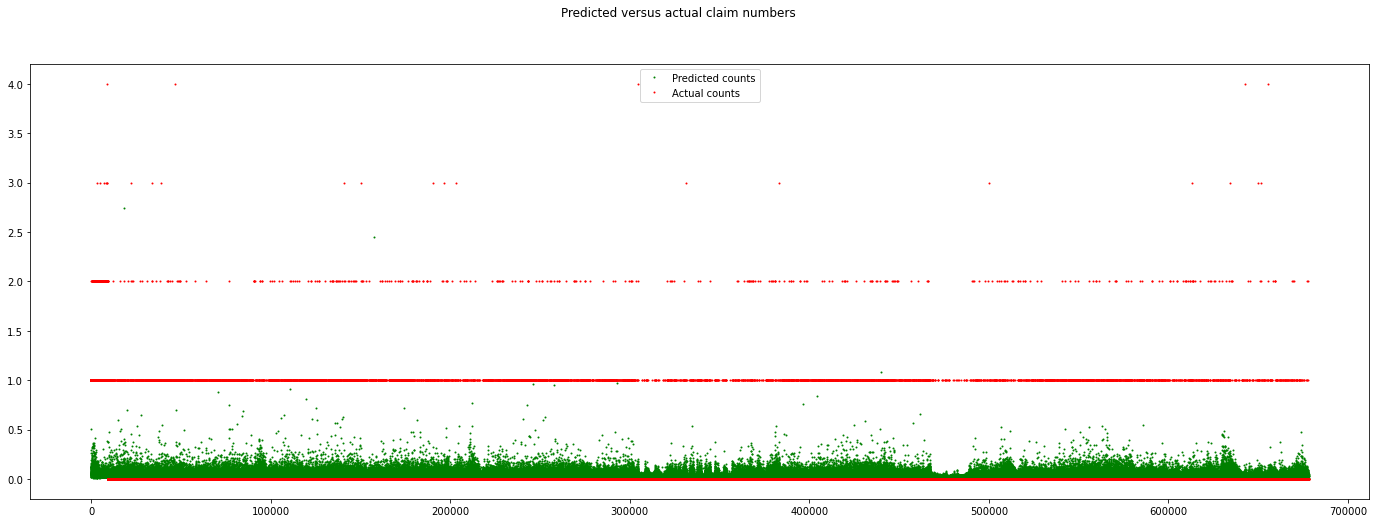

In [31]:
#attempting model with Poisson regression
poisson_model = smf.glm(finalmodeleq, datatrain, family=sm.families.Poisson()).fit(method='nm')
print(poisson_model.summary())

poisson_y_pred = poisson_model.predict(Xte)
poisson_y_fit = poisson_model.fittedvalues
r2_train = ytr.corr(poisson_y_fit) ** 2.
print('R² of y train against y fit =', r2_train)
r2_test = yte.corr(poisson_y_pred) ** 2.
print('R² of y test against y predict =', r2_test)
print('Mean Squared Error:', metrics.mean_squared_error(yte, poisson_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, poisson_y_pred)))
print('Normalised Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, poisson_y_pred))/(float(yte.max()-yte.min())))
#normalise by dividing by range of values in yte
print('MAE:', metrics.median_absolute_error(yte, poisson_y_pred))
#printing various metrics for prediction versus the test data

poisson_model_predictions = poisson_model.get_prediction(Xte)
poisson_predictions_summary_frame = poisson_model_predictions.summary_frame()
poisson_predicted_counts=poisson_predictions_summary_frame['mean']
poisson_actual_counts = yte
fig = pl.figure(figsize=(24, 8))
fig.suptitle('Predicted versus actual claim numbers')
predicted, = pl.plot(Xte.index, poisson_predicted_counts, 'go-', label='Predicted counts', linewidth=0, markersize=1)
actual, = pl.plot(Xte.index, poisson_actual_counts, 'ro-', label='Actual counts', linewidth=0, markersize=1)
pl.legend(handles=[predicted, actual])
pl.show()

#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508263
Model:                            GLM   Df Residuals:                   508255
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0288e+05
Date:                Wed, 31 Mar 2021   Deviance:                   1.3346e+05
Time:                        15:39:26   Pearson chi2:                 5.66e+11
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.86

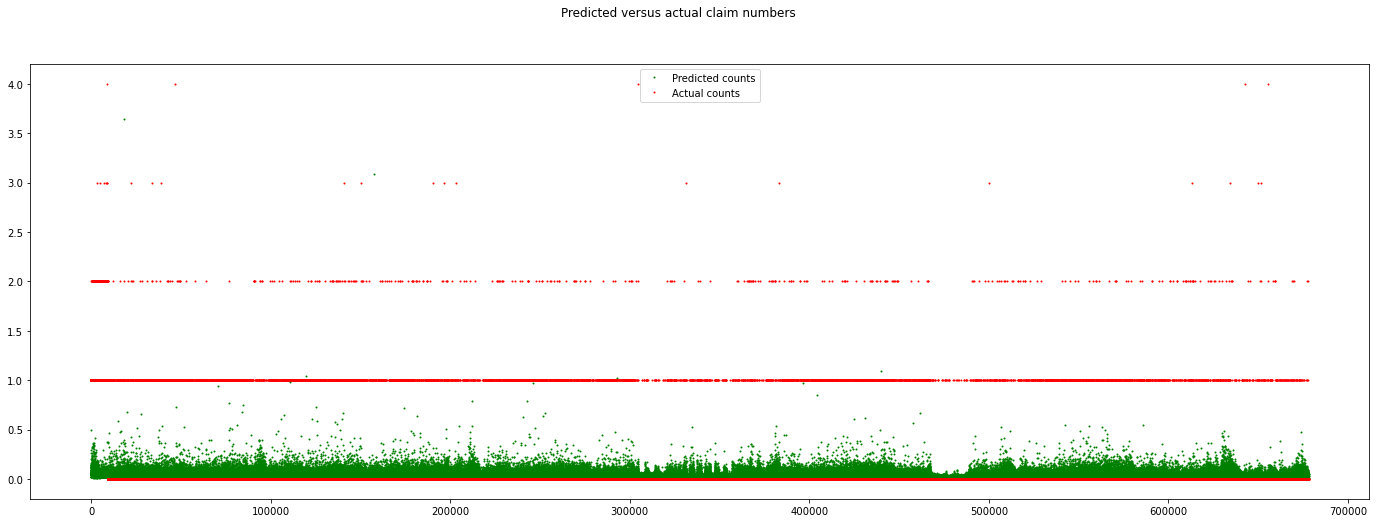

In [36]:
#attempting model with negative binomial regression instead of poisson
negbin_model = smf.glm(finalmodeleq, datatrain, family=sm.families.NegativeBinomial()).fit()
print(negbin_model.summary())

negbin_y_pred = negbin_model.predict(Xte)
negbin_y_fit = negbin_model.fittedvalues
r2_train = ytr.corr(negbin_y_fit) ** 2.
print('R² of y train against y fit =', r2_train)
r2_test = yte.corr(negbin_y_pred) ** 2.
print('R² of y test against y predict =', r2_test)
print('Mean Squared Error:', metrics.mean_squared_error(yte, negbin_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, negbin_y_pred)))
print('Normalised Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, negbin_y_pred))/(float(yte.max()-yte.min())))
#normalise by dividing by range of values in yte
print('MAE:', metrics.median_absolute_error(yte, negbin_y_pred))
#printing various metrics for prediction versus the test data

negbin_model_predictions = negbin_model.get_prediction(Xte)
negbin_predictions_summary_frame = negbin_model_predictions.summary_frame()
negbin_predicted_counts=negbin_predictions_summary_frame['mean']
negbin_actual_counts = yte
fig = pl.figure(figsize=(24, 8))
fig.suptitle('Predicted versus actual claim numbers')
predicted, = pl.plot(Xte.index, negbin_predicted_counts, 'go-', label='Predicted counts', linewidth=0, markersize=1)
actual, = pl.plot(Xte.index, negbin_actual_counts, 'ro-', label='Actual counts', linewidth=0, markersize=1)
pl.legend(handles=[predicted, actual])
pl.show()

#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508263
Model:                            GLM   Df Residuals:                   508255
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0288e+05
Date:                Wed, 31 Mar 2021   Deviance:                   1.3346e+05
Time:                        15:58:37   Pearson chi2:                 5.66e+11
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.86

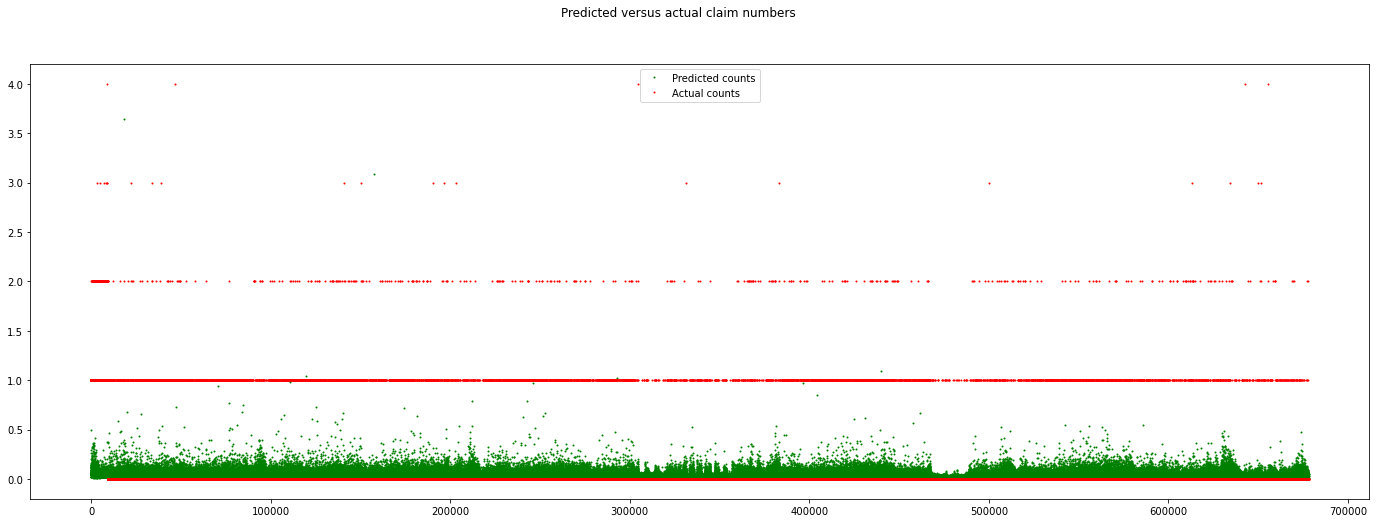

In [39]:
#attempting model with negative binomial regression instead of poisson
OLS_model = smf.ols(finalmodeleq, datatrain).fit()
print(negbin_model.summary())

negbin_y_pred = negbin_model.predict(Xte)
negbin_y_fit = negbin_model.fittedvalues
r2_train = ytr.corr(negbin_y_fit) ** 2.
print('R² of y train against y fit =', r2_train)
r2_test = yte.corr(negbin_y_pred) ** 2.
print('R² of y test against y predict =', r2_test)
print('Mean Squared Error:', metrics.mean_squared_error(yte, negbin_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, negbin_y_pred)))
print('Normalised Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, negbin_y_pred))/(float(yte.max()-yte.min())))
#normalise by dividing by range of values in yte
print('MAE:', metrics.median_absolute_error(yte, negbin_y_pred))
#printing various metrics for prediction versus the test data

negbin_model_predictions = negbin_model.get_prediction(Xte)
negbin_predictions_summary_frame = negbin_model_predictions.summary_frame()
negbin_predicted_counts=negbin_predictions_summary_frame['mean']
negbin_actual_counts = yte
fig = pl.figure(figsize=(24, 8))
fig.suptitle('Predicted versus actual claim numbers')
predicted, = pl.plot(Xte.index, negbin_predicted_counts, 'go-', label='Predicted counts', linewidth=0, markersize=1)
actual, = pl.plot(Xte.index, negbin_actual_counts, 'ro-', label='Actual counts', linewidth=0, markersize=1)
pl.legend(handles=[predicted, actual])
pl.show()

#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958


# Comments

In [43]:
#This dataset has been used in many similar case studies, where Poisson regression was conducted in R,
#as well as in Python.
#In those cases, however, they sought to analyse the frequency (ClaimNb/Exposure) rather than ClaimNb itself,
#as we have been tasked with for this assignment.
#It is intuitive that Poisson distribution would best describe claim frequency (as per background knowledge),
#but this assumption might not hold true when we aim to predict ClaimNb itself.

#Interaction variables, collinearity, variable selection and categorical variables (Area, VehAge, etc) were considered.
#The cleaned dataset was then run through 3 types of regression: GLM(Poisson), GLM(negative binomial) and OLS.
#Of the 3, I chose the Poisson model as it provided the largest R2 for both the model as well as for the y test data against y predicted
#However, all gave very similar R2 in both cases, ranging from 0.018 to 0.019. Normalised RMSE and MAE for all 3 models
#were also similar, in the range of 0.06 and 0.05 respectively. The R2 value is not very satisfactory, and
#perhaps we could improve upon this by making use of other models like zero-inflated Poisson regression,
#or attempting to predict frequency instead of ClaimNb. 

